In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 bird  frog  bird truck


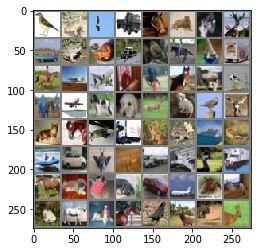

Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 131, in get
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
    if timeout < 0 or not self._poll(timeout):
  File "/

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3,   48, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(48, 384, 5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(384,512, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(512, 64, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64,  10, 3, stride=1, padding=1)
        

    def forward(self, x):
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = self.relu(self.pool(self.conv4(x)))
        x = self.pool(self.conv5(x))
        return x.view(-1,10)


net = Net()
net.to(device)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(48, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(48, 384, 5)
        self.fc1 = nn.Linear(384 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 384 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(48, 384, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=9600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
def val():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print correct, total

    print('Accuracy of the network on the 10000 test images: %.3f %%' % (
        100.0 * correct / total))
    return 100.0 * correct / total

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-3)
def train(epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('%d loss: %.3f' %
          (epoch + 1, running_loss / 1000))
    return running_loss

In [19]:
ttt = 0
rog = 10000
for epoch in range(100):  # loop over the dataset multiple times
    loss = train(epoch)
    if rog < loss:
        break
    else:
        rog = loss
    acc = val()

1 loss: 1.104
Accuracy of the network on the 10000 test images: 57.970 %
2 loss: 0.802
Accuracy of the network on the 10000 test images: 66.300 %
3 loss: 0.681
Accuracy of the network on the 10000 test images: 68.910 %
4 loss: 0.607
Accuracy of the network on the 10000 test images: 70.070 %
5 loss: 0.553
Accuracy of the network on the 10000 test images: 72.210 %
6 loss: 0.502
Accuracy of the network on the 10000 test images: 73.130 %
7 loss: 0.463
Accuracy of the network on the 10000 test images: 74.210 %
8 loss: 0.426
Accuracy of the network on the 10000 test images: 74.220 %
9 loss: 0.396
Accuracy of the network on the 10000 test images: 74.160 %
10 loss: 0.371
Accuracy of the network on the 10000 test images: 74.970 %
11 loss: 0.344
Accuracy of the network on the 10000 test images: 74.140 %
12 loss: 0.324
Accuracy of the network on the 10000 test images: 73.590 %
13 loss: 0.296
Accuracy of the network on the 10000 test images: 73.730 %
14 loss: 0.278
Accuracy of the network on the 1

In [4]:
class oSample(torch.autograd.Function):
    def forward(ctx, inputs):
        N = 16
        Q = pow(2, N-1) - 1
        delt = pow(2,-8)
        M = (inputs/delt).round()
        M[M>=Q] = Q
        M[M<-Q] = -(Q+1)
        S = delt*M
        return S
    def backward(ctx, g):
        return g

def sampleStateDict(net):
    Dict = net.state_dict()
    Key = Dict.keys()
    for i in Key:
        Dict[i] = oSample()(Dict[i])
    net.load_state_dict(Dict)

def protectStateDict(net):
    Dict = net.state_dict()
    Key = Dict.keys()
    for i in Key:
        Dict[i] = Dict[i]*1
    return Dict

In [11]:
class SampleNet(nn.Module):
    def __init__(self):
        super(SampleNet, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3,   48, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(48, 384, 5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(384,512, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(512, 64, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64,  10, 3, stride=1, padding=1)
        

    def forward(self, x):
        x = oSample()(x)
        x = self.relu(self.pool(oSample()(self.conv1(x))))
        x = self.relu(self.pool(oSample()(self.conv2(x))))
        x = self.relu(self.pool(oSample()(self.conv3(x))))
        x = self.relu(self.pool(oSample()(self.conv4(x))))
        x = self.pool(self.conv5(x))
        return x.view(-1,10)


sample_net = SampleNet()
sample_net.to(device)

SampleNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (conv1): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(48, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(384, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [12]:
def val():
    correct = 0
    total = 0
    TMP = protectStateDict(sample_net)
    sampleStateDict(sample_net)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = sample_net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    sample_net.load_state_dict(TMP)
    print('Accuracy of the network on the 10000 test images: %.3f %%' % (
        100.0 * correct / total))
    return 100.0 * correct / total

In [13]:
criterion_s = nn.CrossEntropyLoss()
#optimizer_s = optim.SGD(sample_net.parameters(), lr=0.0001, momentum=0.9)
optimizer_s = optim.Adam(sample_net.parameters(), lr=0.001, weight_decay=1e-3)
def train(epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_s.zero_grad()

        # forward + backward + optimize
        TMP = protectStateDict(sample_net)
        sampleStateDict(sample_net)
        outputs = sample_net(inputs)
        loss = criterion_s(outputs, labels)
        loss.backward()
        sample_net.load_state_dict(TMP)
        optimizer_s.step()

        # print statistics
        running_loss += loss.item()
    print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_loss / 1000))
    return running_loss

In [14]:
import time
ttt = 0
rog = 10000
for epoch in range(1000):  # loop over the dataset multiple times
    a = time.time()
    loss = train(epoch)
    if rog < loss:
        break
    else:
        rog = loss
    acc = val()
    b = time.time()
    print b - a

[1,   782] loss: 1.184
Accuracy of the network on the 10000 test images: 51.210 %
39.6726579666
[2,   782] loss: 0.847
Accuracy of the network on the 10000 test images: 65.100 %
40.0343179703
[3,   782] loss: 0.688
Accuracy of the network on the 10000 test images: 68.800 %
39.6626780033
[4,   782] loss: 0.597
Accuracy of the network on the 10000 test images: 72.550 %
40.0967891216
[5,   782] loss: 0.534
Accuracy of the network on the 10000 test images: 73.870 %
39.6528248787
[6,   782] loss: 0.487
Accuracy of the network on the 10000 test images: 75.900 %
39.6688439846
[7,   782] loss: 0.445
Accuracy of the network on the 10000 test images: 75.500 %
39.5422580242
[8,   782] loss: 0.414
Accuracy of the network on the 10000 test images: 75.020 %
39.7502861023


Process Process-51:
Process Process-52:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run


KeyboardInterrupt: 

    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
  File "/usr/local/lib/python2.7/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 131, in get
  File "/usr/lib/python2.7/multiprocessing/queues.py", line 131, in get
    if timeout < 0 or not self._poll(timeout):
    if timeout < 0 or not self._poll(timeout):
KeyboardInterrupt
KeyboardInterrupt
